# Amplitude Pupil Mask for ZIMPOL
## Local contrast improvement at 2$\lambda$/D

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pupil_masks import *
import os
from skimage.transform import resize
from matplotlib.colors import LogNorm

% matplotlib inline

def myfft2(wave_in, **kwargs):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wave_in), **kwargs))

def myifft2(wave_in, **kwargs):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(wave_in), **kwargs))

def cart2pol(x,y):
    """
    Takes cartesian (2D) coordinates and transforms them into polar.
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def PolarTransform(t, rstep, thetastep_deg):
    N = np.shape(t)[0]
    center = N/2+ 1
    thetastep = thetastep_deg*np.pi/180
    polartrans = np.zeros((int(N/2/rstep), int(360/thetastep_deg)), dtype=np.complex)
    
    rs = np.linspace(0,N/2, int(N/2/rstep), endpoint=False)
    qs = np.linspace(0,2*np.pi, int(2*np.pi/thetastep), endpoint=False)
    Rs, Qs = np.meshgrid(rs, qs)
    
    Ylocs = center + Rs*np.sin(Qs)
    Xlocs = center + Rs*np.cos(Qs)
    Xlocs[Xlocs==N]=N-1
    Ylocs[Ylocs==N]=N-1
    for i in np.arange(0,len(rs)):
        for j in np.arange(0,len(qs)):
            polartrans[i,j] = t[Ylocs[j,i], Xlocs[j,i]]
            
    return polartrans

def iPolarTransform(im, rstep_pix, thetastep_deg):
    num_radii, num_angles = np.shape(im)
    N = int(2*num_radii*rstep_pix)
    ipolartrans_real = np.zeros((N,N),dtype=np.complex)
    ipolartrans_imag = np.zeros((N,N), dtype=np.complex)
    ix = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(ix, ix)
    
    R_i = np.round(np.sqrt(X**2+Y**2)/rstep_pix)+ 1
    Q_i = np.round((np.arctan(Y, X)+np.pi)*180/np.pi/thetastep_deg)+1
    Q_i[Q_i == num_angles] = 1
    R_i[R_i>= num_radii]=1
    
    in_real = np.real(im)
    in_imag = np.imag(im)
    for k in np.arange(0, len(ix)):
        for p in np.arange(0, len(ix)):
            ipolartrans_real[k,p] = in_real[R_i[k,p],Q_i[k,p]]
            ipolartrans_imag[k,p] = in_imag[R_i[k,p],Q_i[k,p]]
    
    ipolartrans = ipolartrans_real + 1j*ipolartrans_imag
    ipolartrans[R_i > num_radii] = 0
    ipolartrans = np.rot90(ipolartrans,2)  
    return ipolartrans
       
def downsample_mask(path, mask_name):
    filename = os.path.join(path, mask_name)
    filename +=  '.fits'
    fpm = fits.getdata(filename)/np.pi
    h = fits.getheader(filename)
    mask_8bit = (fpm+1)*256/2
    mask_8bit = mask_8bit.astype(np.uint8)
    hdu = fits.PrimaryHDU(data=mask_8bit)
    savename = os.path.join(path, mask_name) + '_8bit.fits'
    hdu.header = h
    hdu.writeto(savename)
    return mask_8bit

def plot_im_ld(image, ld, w, n=2,color='viridis', log_scale=False, v_min=0, v_max=1, log_max=0, log_min=-3):
    l = np.shape(image)[0]
    n0 = int(l/2)
    
    crop = image[n0-w*ld:n0+w*ld, n0-w*ld:n0+w*ld]
    norm = None
    if log_scale:        
        v_min = 10**log_min
        v_max = 10**log_max      
        norm = LogNorm() 

        
    n1 = int(np.shape(crop)[0]/2)
    
    plt.imshow(crop,interpolation='nearest', cmap=color, norm=norm, vmin=v_min, vmax=v_max)
    labs = np.arange(-w, w+2, 2)
    locs = np.arange(0, 2*w*ld+ld, 2*ld)
    plt.xticks(locs, [str(abs(lab)) for lab in labs])
    plt.yticks(locs[:-1], [str(abs(lab)) for lab in labs[:-1]])
    circ=plt.Circle((n1,n1), radius=n*ld, color='red',linewidth=1.2, linestyle='--', alpha=1, fill=False)
    plt.gca().add_patch(circ)
    plt.colorbar()
    return

def plot_im_LP(LP, apRad, w, color='gray', **kwargs):
    l = np.shape(LP)[0]
    n0 = int(l/2)
    w = apRad*w + apRad
    crop = LP[n0-w:n0+w, n0-w:n0+w]
    plt.imshow(crop, interpolation='nearest', cmap=color, **kwargs)
    plt.colorbar()
    return

def calculate_contrast_curve(PSF, lD):
    rad = 8*lD
    flux = []
    for r in np.arange(0,8*lD):
        flux.append(np.mean(PSF[np.where(RHO==r)]))
    x = np.arange(len(flux))/lD
    return x, flux

def throughputLP(LP, LS, EP):
    return np.sum((LP*LS)**2)/np.sum((EP*LS)**2)

N = 4096
x = np.arange(-1024/2, 1024/2)
y = np.arange(-1024/2, 1024/2)
X, Y = np.meshgrid(x,y)

RHOs, THETAs = cart2pol(X,Y) 


def wfe_rms(strehl, wavelength):
    return np.sqrt(-np.log(strehl))

def wf_jitter(strehl, wavelength,N, samples, a=1,b=20, no_filter=True):
    if no_filter:
        mu = 0  # ideal wavefront at 0 phase difference
        sigma = wfe_rms(strehl, wavelength)
        wfj = np.random.normal(mu, sigma, (N,N))
    else:
        wfj_ft = myfft2(wfj)
        filter_fwhm = np.ones((N,N))
        filter_fwhm[np.where((RHO<=10*a)&(RHO>10*b))] = 0
        wfj_ft *=filter_fwhm
        wfj_filtered = myifft2(wfj_ft)
        sigma_filtered = [np.max(np.abs(np.real(wfj_filtered[i])))/sigma for i in range(samples)]
        wfj_filtered = [np.real(wfj_filtered[i]/sigma_filtered[i]) for i in range(samples)]
    return wfj

def polychromaticEP(pupil_func, apRad,l, lc ,RHO, strehl, N=4096,samples=10,aberration=False, **kwargs):
    r = apRad*lc/l
    if aberration:
        wfj = wf_jitter(strehl, l, N, samples)
        return pupil_func(r,**kwargs)*np.exp(1j*wfj)
    else:
        return pupil_func(r,**kwargs)

def polychromaticPSF(apRad, N, lc, bw, lbins, source_spectrum, filter_trans, RHO, strehl, samples=None, aberration=False):
    lmin = lc - 0.5*bw
    lmax = lc + 0.5*bw
    
    print("Wavelength range [nm] %f - %f"%(lmin, lmax))
    wavelengths = np.linspace(lmin, lmax,num=lbins,endpoint=True)
    ss_digitized = np.digitize(np.arange(len(source_spectrum)), np.linspace(0,len(source_spectrum),lbins+1))
    ss_binned = np.array([source_spectrum[ss_digitized==i].mean() for i in range(1, lbins+1)])
    ft_digitized = np.digitize(np.arange(len(filter_trans)),np.linspace(0,len(filter_trans),lbins+1))
    ft_binned = np.array([filter_trans[ft_digitized==i].mean() for i in range(1, lbins+1)])
    plt.subplot(221)
    plt.plot(wavelengths, ss_binned,'o')
    plt.gca().set_title("Spectrum")
    plt.subplot(222)
    plt.plot(wavelengths, ft_binned,'o')
    plt.gca().set_title("Filter transmission")
    """plt.subplot(212)
    plt.plot(wavelengths, ft_binned)
    plt.gca().set_title("Filter transmission")"""
    if aberration and (samples is not None):
        PSF = np.zeros((samples,N,N))
        PSFopt = np.zeros((samples,N,N))
    else:
        PSF = np.zeros((N,N))
        PSFopt = np.zeros((N,N))
    for i in np.arange(0,lbins):
        print("Calculating PSF for VLT @%f nm.."%(wavelengths[i]))
        PSF += ft_binned[i]*ss_binned[i]*np.abs(myfft2(polychromaticEP(VLT_pupil,apRad, wavelengths[i],lc,
                                                                       RHO, strehl=strehl, N=N,samples=samples)))**2
        PSFopt += ft_binned[i]*ss_binned[i]*np.abs(myfft2(polychromaticEP(optimized_VLT_pupil,apRad,wavelengths[i],lc,
                                                                          RHO,strehl=strehl, N=N,samples=samples)))**2
    print("Done. Normalizing..")   
    norm = np.max(PSF)
    PSF /= norm
    PSFopt /= norm
    return PSF, PSFopt
    
        
def optimized_VLT_pupil(r,a=0.765,b=0.205, spiders=False):
    """
    Ring center a=0.765 
    Ring width  b=0.205
    """
    p = make_VLT_pupil(1024,r, spiders=spiders)
    p[np.where((RHOs>(a-0.5*b)*r) & (RHOs<(a+0.5*b)*r))]=0
    p = np.lib.pad(p, (1536, 1536), 'constant', constant_values=(0,0))
    return p
    
def VLT_pupil(r,spiders=False):
    p = make_VLT_pupil(1024,r, spiders=spiders)
    p = np.lib.pad(p, (1536, 1536), 'constant', constant_values=(0,0))
    return p

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

tip = lambda r, theta: 2*r*np.cos(theta)
tilt = lambda r, theta: 2*r*np.sin(theta)
defocus = lambda r, theta: 0.3*np.sqrt(3)*(2*r**2-1)
astigm45 = lambda r, theta: 0.3*np.sqrt(6)*(r**2)*np.sin(2*theta)
coma45 = lambda r, theta: 0.3*np.sqrt(8)*(2*r**3-2*r)*np.sin(theta)
astigm0 = lambda r, theta: 0.3*np.sqrt(6)*(r**2)*np.cos(2*theta)
coma0 = lambda r, theta: 0.3*np.sqrt(8)*(2*r**3-2*r)*np.cos(theta)

def simulation_tiptilt(coadds, delta, strehl, l, lc, calib,lambdaOverD=10):
    PSF = np.zeros((N,N))
    PSFopt = np.zeros((N,N))
    sigma = np.sqrt(-np.log(strehl))
    for i in np.arange(coadds):
        delta1 = np.random.uniform(low=-delta,high=delta) #nm
        delta2 = np.random.uniform(low=-delta,high=delta)
        aberration = np.exp(1j*delta1*tilt(RHO,THETA)/(2*np.pi*l*lambdaOverD))*np.exp(1j*delta2*tip(RHO,THETA)/(2*np.pi*l*lambdaOverD)) 
        wfj = np.random.normal(0, sigma*l/lc, (N,N))
        PSF += np.abs(myfft2(EP*aberration*np.exp(1j*wfj)))**2/calib
        PSFopt += np.abs(myfft2(EPopt*aberration*np.exp(1j*wfj)))**2/calib
    f4 = np.sum(PSF[np.where(OPT_REG_FP==1)])
    f5 = np.sum(PSFopt[np.where(OPT_REG_FP==1)])
    through = np.max(PSFopt)/np.max(PSF)

    print("VLT-->""Throughput: ",np.max(PSFopt))
    print("VLT opt-->""Throughput: ",through, "Contrast Improv. ", 1/(f5/f4),"\n",
      "Corrected for throughput: ", through/(f5/f4))
    return PSF, PSFopt, f4, f5



/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:122: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4


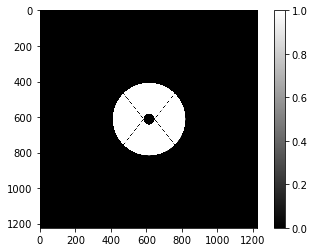

In [2]:
% matplotlib inline
# initialize simulation
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 10
apRad = int(N/(2*lambdaOverD))


EP = make_VLT_pupil(1024, apRad, spiders=True)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))

EPopt = optimized_VLT_pupil(apRad, spiders=True)

plot_im_LP(EP, apRad, 2)


In [3]:
hdu = fits.PrimaryHDU(data=[EP, EPopt])
hdu.writeto("VLTpupils_nominal_spiders.fits")

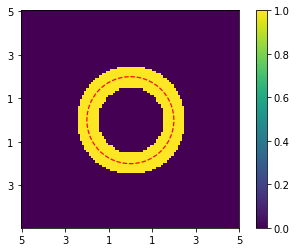

In [4]:
OPT_REG_FP = np.zeros((N,N))
OPT_REG_FP[np.where(RHO<2.5*lambdaOverD)] = 1
OPT_REG_FP[np.where(RHO<1.5*lambdaOverD)] = 0
plot_im_ld(OPT_REG_FP, lambdaOverD, 5)

## Monochromatic case @750 nm

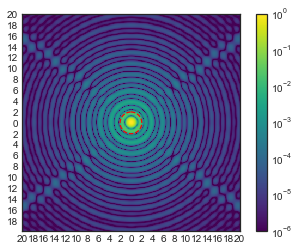

In [5]:
plt.style.use("seaborn-white")
# Nominal PSF for VLT with a 10 pixel sampling
PSF = np.abs(myfft2(EP))**2 
calib = np.max(PSF)
PSF /= calib
plot_im_ld(PSF, 10, 20, log_scale=True, log_min=-6, n=2)

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:122: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4


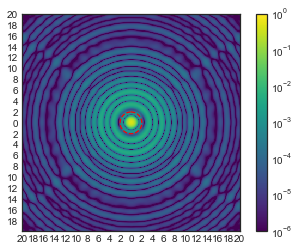

In [6]:
# Optimised VLT pupil with ring amplitude apodizer

EPopt = optimized_VLT_pupil(apRad,spiders=True)
PSFopt = np.abs(myfft2(EPopt))**2/calib
plot_im_ld(PSFopt, 10, 20, log_scale=True, log_min=-6, n=2)

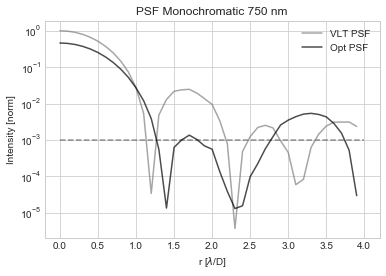

In [7]:
plt.style.use("seaborn-whitegrid")
start = 2048
end = 2088
psf1d = np.array([np.median(PSF[np.where(RHO == r)]) for r in np.arange(0,40)])
psfopt1d = np.array([np.median(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])

r = np.arange(0,40)/10
plt.semilogy(r, psf1d, linewidth=1.5, alpha=0.7,c="gray", label="VLT PSF")
plt.semilogy(r, psfopt1d, linewidth=1.5, alpha=0.7,c="black", label="Opt PSF")
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.title("PSF Monochromatic 750 nm")
plt.legend()

In [8]:
f4 = np.sum(PSF[np.where(OPT_REG_FP==1)])
f5 = np.sum(PSFopt[np.where(OPT_REG_FP==1)])
c1 = np.mean(PSF[np.where(OPT_REG_FP==1)])
c2 = np.mean(PSFopt[np.where(OPT_REG_FP==1)])
through = np.max(PSFopt)
print("VLT opt-->""Throughput: ",round(through, 2), round((f5/f4),4), "Contrast Improv. ", round(1/(f5/f4),2),"\n",
      "Corrected for throughput: ", round(through/(f5/f4),2), "Average contrast", c1, c2)

VLT opt-->Throughput:  0.46 0.0528 Contrast Improv.  18.94 
 Corrected for throughput:  8.71 Average contrast 0.00992513517931 0.000523981589425


## Effect of chromaticity 

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


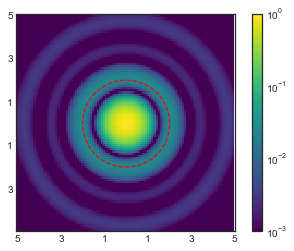

In [14]:
ep950 = polychromaticEP(VLT_pupil, apRad, 950, 750, RHO,0.9)
psf950 = np.abs(myfft2(ep950))**2
plt.style.use("seaborn-white")
plot_im_ld(psf950/np.max(psf950), 10, 5, log_scale=True, log_min=-3, n=2)

Wavelength range [nm] 775.000000 - 1025.000000
Calculating PSF for VLT @775.000000 nm..


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Calculating PSF for VLT @788.157895 nm..
Calculating PSF for VLT @801.315789 nm..
Calculating PSF for VLT @814.473684 nm..
Calculating PSF for VLT @827.631579 nm..
Calculating PSF for VLT @840.789474 nm..
Calculating PSF for VLT @853.947368 nm..
Calculating PSF for VLT @867.105263 nm..
Calculating PSF for VLT @880.263158 nm..
Calculating PSF for VLT @893.421053 nm..
Calculating PSF for VLT @906.578947 nm..
Calculating PSF for VLT @919.736842 nm..
Calculating PSF for VLT @932.894737 nm..
Calculating PSF for VLT @946.052632 nm..
Calculating PSF for VLT @959.210526 nm..
Calculating PSF for VLT @972.368421 nm..
Calculating PSF for VLT @985.526316 nm..
Calculating PSF for VLT @998.684211 nm..
Calculating PSF for VLT @1011.842105 nm..
Calculating PSF for VLT @1025.000000 nm..
Done. Normalizing..


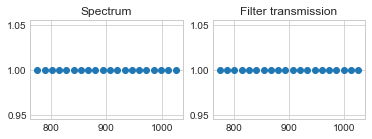

In [11]:
lc = 900 # central wavelength in nm

source_spectrum = np.ones(100)
filter_trans = np.ones(100) #gaussian(np.arange(100),50,40)
PSFbd, PSFoptbd = polychromaticPSF(apRad, N, lc, 250,20, source_spectrum, filter_trans, RHO, 
                               strehl=0.4, samples=None, aberration=False)



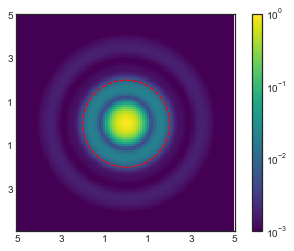

In [12]:
plt.style.use("seaborn-white")
plot_im_ld(PSFbd, 10, 5, log_scale=True, log_min=-3, n=2)

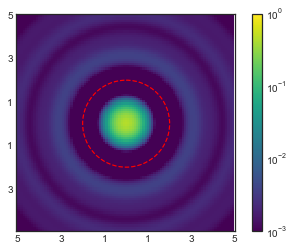

In [13]:
plot_im_ld(PSFoptbd, 10, 5, log_scale=True, log_min=-3, n=2)

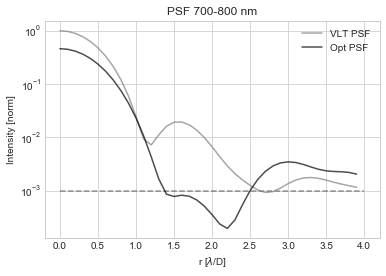

In [10]:
plt.style.use("seaborn-whitegrid")
start = 2048
end = 2088
psf1d = np.array([np.median(PSFbd[np.where(RHO == r)]) for r in np.arange(0,40)])
psfopt1d = np.array([np.median(PSFoptbd[np.where(RHO == r)]) for r in np.arange(0,40)])

r = np.arange(0,40)/10
plt.semilogy(r, psf1d, linewidth=1.5, alpha=0.7,c="gray", label="VLT PSF")
plt.semilogy(r, psfopt1d, linewidth=1.5, alpha=0.7,c="black", label="Opt PSF")
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.title("PSF 700-800 nm")
plt.legend()

In [97]:
f4 = np.sum(PSFbd[np.where(OPT_REG_FP==1)])
f5 = np.sum(PSFoptbd[np.where(OPT_REG_FP==1)])
c1 = np.mean(PSFbd[np.where(OPT_REG_FP==1)])
c2 = np.mean(PSFoptbd[np.where(OPT_REG_FP==1)])
through = np.max(PSFoptbd)
print("VLT opt-->""Throughput: ",round(through, 2), round((f5/f4),4), "Contrast Improv. ", round(1/(f5/f4),2),"\n",
      "Corrected for throughput: ", round(through/(f5/f4),2), "Average contrast", c1, c2)

VLT opt-->Throughput:  0.46 0.0485 Contrast Improv.  20.64 
 Corrected for throughput:  9.51 Average contrast 0.00936100580841 0.000453590345233


For bandwidth: 30
Wavelength range [nm] 735.000000 - 765.000000
Calculating PSF for VLT @735.000000 nm..


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Calculating PSF for VLT @738.333333 nm..
Calculating PSF for VLT @741.666667 nm..
Calculating PSF for VLT @745.000000 nm..
Calculating PSF for VLT @748.333333 nm..
Calculating PSF for VLT @751.666667 nm..
Calculating PSF for VLT @755.000000 nm..
Calculating PSF for VLT @758.333333 nm..
Calculating PSF for VLT @761.666667 nm..
Calculating PSF for VLT @765.000000 nm..
Done. Normalizing..
For bandwidth: 50
Wavelength range [nm] 725.000000 - 775.000000
Calculating PSF for VLT @725.000000 nm..
Calculating PSF for VLT @730.555556 nm..
Calculating PSF for VLT @736.111111 nm..
Calculating PSF for VLT @741.666667 nm..
Calculating PSF for VLT @747.222222 nm..
Calculating PSF for VLT @752.777778 nm..
Calculating PSF for VLT @758.333333 nm..
Calculating PSF for VLT @763.888889 nm..
Calculating PSF for VLT @769.444444 nm..
Calculating PSF for VLT @775.000000 nm..
Done. Normalizing..
For bandwidth: 75
Wavelength range [nm] 712.500000 - 787.500000
Calculating PSF for VLT @712.500000 nm..
Calculating 

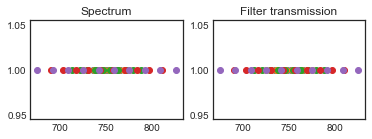

In [104]:
psf1d = []
psfopt1d = []
f = []
fopt = []
for bw in [30, 50, 75, 120, 150]:
    print("For bandwidth: %i"%bw)
    psfbd, psfoptbd = polychromaticPSF(apRad, N, lc, bw, 10, source_spectrum, filter_trans, RHO, 
                                       strehl=0.7, samples=None, aberration=False)
    psf1d.append(np.array([np.median(psfbd[np.where(RHO == r)]) for r in np.arange(0,40)]))
    psfopt1d.append(np.array([np.median(psfoptbd[np.where(RHO == r)]) for r in np.arange(0,40)]))
    f.append(np.sum(PSFtt[np.where(OPT_REG_FP==1)]))
    fopt.append(np.sum(PSFoptt[np.where(OPT_REG_FP==1)]))
    
    
    



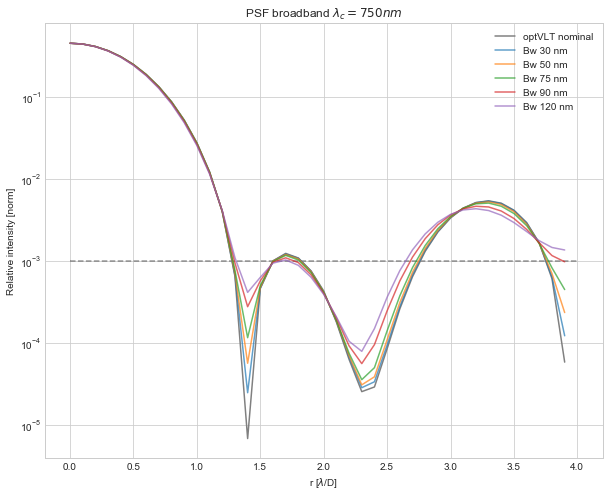

In [106]:
popt = np.array([np.median(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])

plt.style.use("seaborn-whitegrid")
r = np.arange(0,40)/10
plt.figure(figsize=(10,8))
plt.semilogy(r, popt, linewidth=1.5, alpha=1,c="gray", label="optVLT nominal")
bandwidth = [30, 50, 75, 120, 150]
for i in range(5):
    plt.semilogy(r, psfopt1d[i], linewidth=1.5, alpha=0.7, label="Bw %i nm"%delta[i])
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Relative intensity [norm]")
plt.title("PSF broadband $\lambda_c =750 nm$")
plt.legend()

## Effect of tip tilt terms

In [100]:
lc = 750
PSFtt , PSFopttt, f, fopt= simulation_tiptilt(100,75, 0.99, lc, lc, calib)

VLT-->Throughput:  42.6828334414
VLT opt-->Throughput:  0.464103564004 Contrast Improv.  20.7296167301 
 Corrected for throughput:  9.62068900488


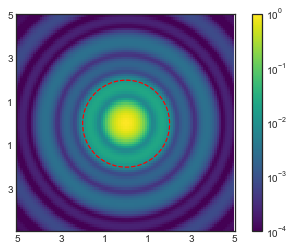

In [101]:
plt.style.use("seaborn-white")
plot_im_ld(PSFtt/np.max(PSFtt), 10, 5, log_scale=True, log_min=-4, n=2)

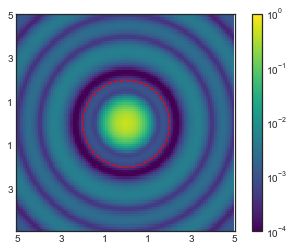

In [102]:
plot_im_ld(PSFopttt/np.max(PSFtt), 10, 5, log_scale=True, log_min=-4, n=2)

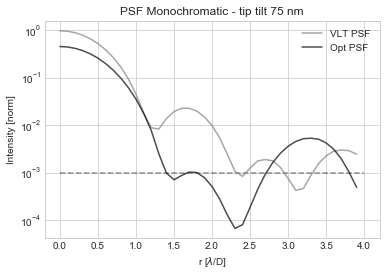

In [32]:
plt.style.use("seaborn-whitegrid")
start = 2048
end = 2088
psf1d = np.array([np.median(PSFtt[np.where(RHO == r)]) for r in np.arange(0,40)])/np.max(PSFtt)
psfopt1d = np.array([np.median(PSFopttt[np.where(RHO == r)]) for r in np.arange(0,40)])/np.max(PSFtt)

r = np.arange(0,40)/10
plt.semilogy(r, psf1d, linewidth=1.5, alpha=0.7,c="gray", label="VLT PSF")
plt.semilogy(r, psfopt1d, linewidth=1.5, alpha=0.7,c="black", label="Opt PSF")
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.title("PSF Monochromatic - tip tilt 75 nm")
plt.legend()

In [99]:
f4 = np.sum(PSFtt[np.where(OPT_REG_FP==1)])/np.max(PSFtt)
f5 = np.sum(PSFopttt[np.where(OPT_REG_FP==1)])/np.max(PSFtt)
c1 = np.mean(PSFtt[np.where(OPT_REG_FP==1)])
c2 = np.mean(PSFopt[np.where(OPT_REG_FP==1)])
through = np.max(PSFopttt)/np.max(PSFtt)
print("VLT opt-->""Throughput: ",round(through, 2), round((f5/f4),4), "Contrast Improv. ", round(1/(f5/f4),2),"\n",
      "Corrected for throughput: ", round(through/(f5/f4),2), "Average contrast", c1, c2)

VLT opt-->Throughput:  0.46 0.0482 Contrast Improv.  20.74 
 Corrected for throughput:  9.63 Average contrast 0.0924801584396 0.000466329312823


In [35]:
psf1d = []
psfopt1d = []
f = []
fopt = []
for d in [30,50, 75, 90, 120, 150]:
    print("Amplitude : %i"%d)
    PSFt , PSFoptt, f1, f2= simulation_tiptilt(10,d, 0.99, lc, lc, calib)
    psf1d.append(np.array([np.median(PSFt[np.where(RHO == r)]) for r in np.arange(0,40)])/np.max(PSFt))
    psfopt1d.append(np.array([np.median(PSFoptt[np.where(RHO == r)]) for r in np.arange(0,40)])/np.max(PSFt))
    f.append(np.sum(PSFtt[np.where(OPT_REG_FP==1)])/np.max(PSFt))
    fopt.append(np.sum(PSFoptt[np.where(OPT_REG_FP==1)])/np.max(PSFt))



Amplitude : 30
VLT-->Throughput:  4.52143645465
VLT opt-->Throughput:  0.461771665087 Contrast Improv.  20.7366474985 
 Corrected for throughput:  9.57559624372
Amplitude : 50
VLT-->Throughput:  4.41387100911
VLT opt-->Throughput:  0.462752899816 Contrast Improv.  20.8302229721 
 Corrected for throughput:  9.63924608414
Amplitude : 75
VLT-->Throughput:  4.37394874661
VLT opt-->Throughput:  0.463093796127 Contrast Improv.  20.6766304392 
 Corrected for throughput:  9.57521928121
Amplitude : 90
VLT-->Throughput:  4.17901212536
VLT opt-->Throughput:  0.464946113251 Contrast Improv.  20.4434036193 
 Corrected for throughput:  9.50508105444
Amplitude : 120
VLT-->Throughput:  3.88257556052
VLT opt-->Throughput:  0.468093853472 Contrast Improv.  18.4669708416 
 Corrected for throughput:  8.64427554319
Amplitude : 150
VLT-->Throughput:  3.82926295806
VLT opt-->Throughput:  0.468753968157 Contrast Improv.  18.891898603 
 Corrected for throughput:  8.85565243619


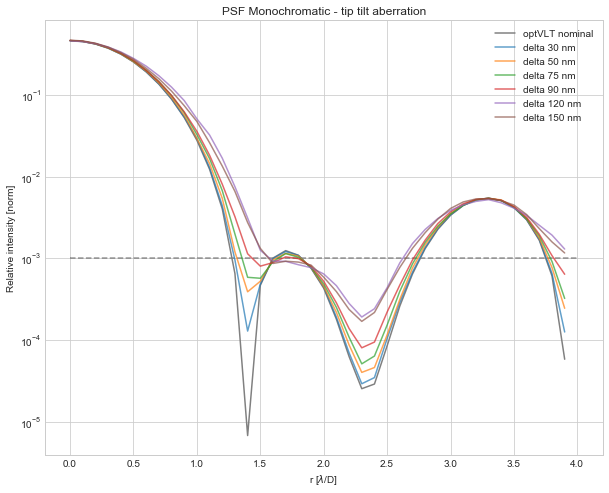

In [46]:
popt = np.array([np.median(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])

plt.style.use("seaborn-whitegrid")
r = np.arange(0,40)/10
plt.figure(figsize=(10,8))
plt.semilogy(r, popt, linewidth=1.5, alpha=1,c="gray", label="optVLT nominal")
delta = [30, 50, 75, 90, 120, 150]
for i in range(6):
    plt.semilogy(r, psfopt1d[i], linewidth=1.5, alpha=0.7, label="delta %i nm"%delta[i])
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Relative intensity [norm]")
plt.title("PSF Monochromatic - tip tilt aberration")
plt.legend()



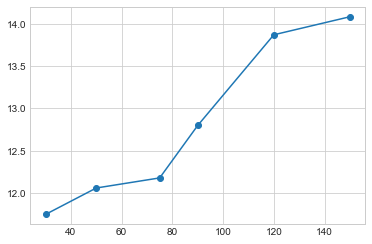

In [39]:
f1 = np.sum(PSFopt[np.where(OPT_REG_FP==1)])/np.max(PSF)
fcorr = [(fopt[i]/f1) for i in range(6)]
plt.plot(delta, f, "-o")
plt.ylabel("")

## Effect of wavefront jitter

In [48]:
strehl = 0.7

PSFstrehl = 0
PSFoptstrehl = 0
for i in range(10):
    EP = polychromaticEP(VLT_pupil, apRad, 750, 750, RHO, strehl=0.7, aberration=True)
    EPopt = polychromaticEP(optimized_VLT_pupil, apRad, 750, 750, RHO, strehl=0.7, aberration=True)
    PSFstrehl += np.abs(myfft2(EP))**2/calib
    PSFoptstrehl += np.abs(myfft2(EPopt))**2/calib
    print(np.max(PSFstrehl))



/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


In [57]:
PSFstrehl /= 10
PSFoptstrehl /= 10

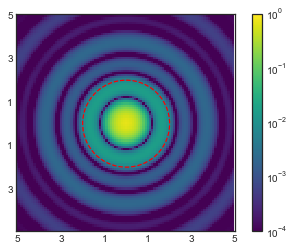

In [58]:
plt.style.use("seaborn-white")
plot_im_ld(PSFstrehl, 10, 5, log_scale=True, log_min=-4, n=2)

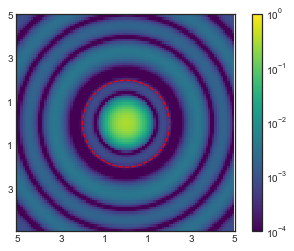

In [59]:
plot_im_ld(PSFoptstrehl, 10, 5, log_scale=True, log_min=-4, n=2)

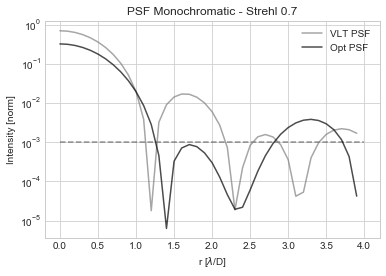

In [64]:
plt.style.use("seaborn-whitegrid")
start = 2048
end = 2088
psf1d = np.array([np.median(PSFstrehl[np.where(RHO == r)]) for r in np.arange(0,40)])
psfopt1d = np.array([np.median(PSFoptstrehl[np.where(RHO == r)]) for r in np.arange(0,40)])

r = np.arange(0,40)/10
plt.semilogy(r, psf1d, linewidth=1.5, alpha=0.7,c="gray", label="VLT PSF")
plt.semilogy(r, psfopt1d, linewidth=1.5, alpha=0.7,c="black", label="Opt PSF")
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Intensity [norm]")
plt.title("PSF Monochromatic - Strehl 0.7")
plt.legend()

In [63]:
f4 = np.sum(PSFstrehl[np.where(OPT_REG_FP==1)])/np.max(PSF)
f5 = np.sum(PSFoptstrehl[np.where(OPT_REG_FP==1)])/np.max(PSF)
through = np.max(PSFoptstrehl)
print("VLT opt-->""Throughput: ",round(through, 2), "Contrast Improv. ", round(1/(f5/f4),2),"\n",
      "Corrected for throughput: ", round(through/(f5/f4),2))

VLT opt-->Throughput:  0.32 Contrast Improv.  20.53 
 Corrected for throughput:  6.64


In [66]:
strehl = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
psf1d = []
psfopt1d = []

PSFstrehl = []
PSFoptstrehl = []

for s in strehl:
    psf, psfopt = 0, 0
    print("Strehl ratio: %f"%s)
    for i in range(10):
        EP = polychromaticEP(VLT_pupil, apRad, 750, 750, RHO, strehl=s, aberration=True)
        EPopt = polychromaticEP(optimized_VLT_pupil, apRad, 750, 750, RHO, strehl=s, aberration=True)
        psf += np.abs(myfft2(EP))**2/calib
        psfopt += np.abs(myfft2(EPopt))**2/calib
    PSFstrehl.append(psf/10)
    PSFoptstrehl.append(psfopt/10)
    psf1d.append(np.array([np.median(psf[np.where(RHO == r)]) for r in np.arange(0,40)])/10)
    psfopt1d.append(np.array([np.median(psfopt[np.where(RHO == r)]) for r in np.arange(0,40)])/10)
                    



Strehl ratio: 0.400000


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:124: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


Strehl ratio: 0.500000
Strehl ratio: 0.600000
Strehl ratio: 0.700000
Strehl ratio: 0.800000
Strehl ratio: 0.900000
Strehl ratio: 0.950000


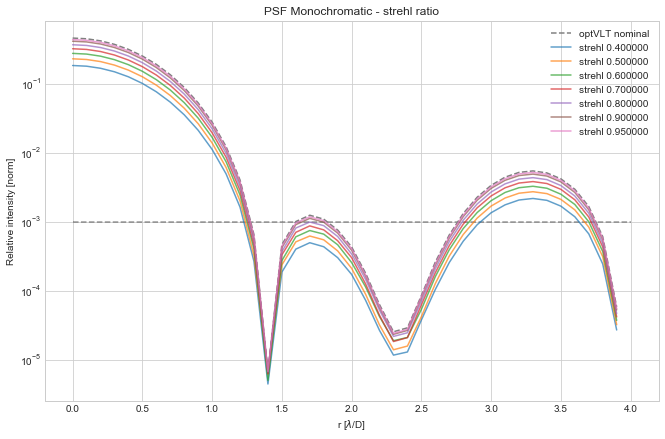

In [70]:
popt = np.array([np.median(PSFopt[np.where(RHO == r)]) for r in np.arange(0,40)])

plt.style.use("seaborn-whitegrid")
r = np.arange(0,40)/10
plt.figure(figsize=(11,7))
plt.semilogy(r, popt, '--', linewidth=1.5, alpha=1,c="gray", label="optVLT nominal")
for i in range(7):
    plt.semilogy(r, psfopt1d[i], linewidth=1.5, alpha=0.7, label="strehl %f"%strehl[i])
plt.hlines(1E-3, xmin=0,xmax=4,color='black',linestyles="--", alpha=0.4)
plt.xlabel("r [$\lambda$/D]")
plt.ylabel("Relative intensity [norm]")
plt.title("PSF Monochromatic - strehl ratio")
plt.legend()



In [72]:
f = [np.sum(PSF[np.where(OPT_REG_FP==1)])]
fopt = [np.sum(PSFopt[np.where(OPT_REG_FP==1)])]
for i in range(7):
    f.append(np.sum(PSFstrehl[i][np.where(OPT_REG_FP==1)]))
    fopt.append(np.sum(PSFoptstrehl[i][np.where(OPT_REG_FP==1)]))
    


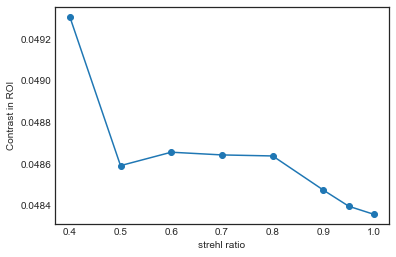

In [84]:
strehl = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]

c = [fopt[i]/f[i] for i in range(8)] 

plt.plot(strehl,c,  '-o')
plt.xlabel("strehl ratio")
plt.ylabel("Contrast in ROI")

## Effect of pupil misalignment

In [ ]:
EPmis = EP*optimized_VLT_pupil(RHO+0.5,spiders=True)


In [ ]:
EP = make_VLT_pupil()